In [ ]:
!pip install keras==2.3.1
!pip install tensorflow-gpu==1.15.2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Flatten,Input,Dropout,BatchNormalization,Activation,Conv2DTranspose,Conv2D,Lambda,Multiply,Embedding,Concatenate,GaussianNoise,MaxPool2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import layers
from tensorflow import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
import tensorflow.keras.backend as k
 
import os, cv2, random
from sklearn.utils import shuffle
import numpy as np
import gc
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import tensorflow as tf

Using TensorFlow backend.


In [22]:
tf.__version__

'1.15.2'

In [150]:
img_shape = (64,64,3)
z_dim=2048
classes=11

In [157]:
def build_cgan_generator(z_dim):
    z_input = Input(shape=(z_dim,))
    label_input = Input(shape=(1,),dtype='int32')
    label_embedding = Embedding(classes,output_dim=z_dim,input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)
    join_represent = Multiply()([z_input,label_embedding])
    
    x = Dense(2048)(join_represent)
    
    x = Reshape((2, 2, 512))(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(256, (5, 5), padding='same', strides=2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(128, (5, 5), padding='same', strides=2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(64, (5, 5), padding='same', strides=2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)

    x = Conv2DTranspose(32, (5, 5), padding='same', strides=2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2DTranspose(3, (5, 5), padding='same', strides=2)(x)
    output = keras.layers.Activation('tanh')(x)


    output = keras.layers.Activation('tanh')(x)

    model = keras.Model([z_input,label_input],output)
    tf.keras.utils.plot_model(model,to_file='generator.png',show_shapes=True)
    return model

In [152]:
def build_cgan_discriminator(img_shape):
    img_input = Input(shape=img_shape)
 
    x = GaussianNoise(0.1)(img_input)
    
    x = Conv2D(64, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPool2D()(x)

    x = Conv2D(128, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
        
    x = Conv2D(256, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)
        
    x = Conv2D(512, (3, 3), padding='same', strides = 2)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.2)(x)


    label_input = Input(shape=(1,))

    label_embedding = Embedding(classes,output_dim=z_dim,input_length=1)(label_input)
    label_embedding = Flatten()(label_embedding)
    flat_img = Flatten()(x)

    join_represent = Multiply()([flat_img,label_embedding])

    x=layers.Dropout(0.3)(join_represent)

    outputs = layers.Dense(1,activation='sigmoid',name='Output')(x)
    model = keras.Model([img_input,label_input],outputs)
    tf.keras.utils.plot_model(model,to_file='discriminator.png',show_shapes=True)

    return model

def build_cgan(generator,discriminator):
    z_input = Input(shape=(z_dim,))
    label_input = Input(shape=(1,),dtype='int32')
    
    img = generator([z_input,label_input])
    classification = discriminator([img,label_input])
    model = keras.Model([z_input,label_input],classification)
    return model

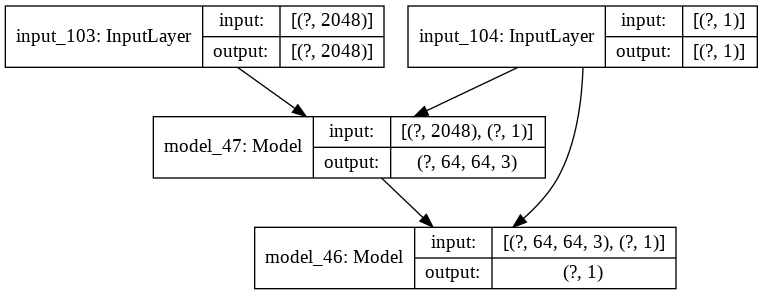

In [158]:
opt = tf.keras.optimizers.Adam()
 
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
 
discriminator.trainable=False#鎖住，只訓練生成器
generator = build_cgan_generator(z_dim)
cgan = build_cgan(discriminator=discriminator,generator=generator)
cgan.compile(optimizer=opt, loss='binary_crossentropy')
tf.keras.utils.plot_model(cgan,show_shapes=True)

In [159]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

dataset_path = ['/content/drive/MyDrive/ColabNotebooks/food11/training',
         '/content/drive/MyDrive/ColabNotebooks/food11/evaluation',
         '/content/drive/MyDrive/ColabNotebooks/food11/validation']
 

def get_dataset(path):
  x,y = [],[]
  dataset = dset.ImageFolder(path,transforms.Compose([transforms.Resize((img_shape[0],img_shape[1]))]))
  class_names = dataset.classes
  for img,label in dataset:
        print(len(y),end=',')
        x.append(np.array(img))
        y.append(label)
    
  dataset = list(zip(x, y))
  random.shuffle(dataset)
  x, y = zip(*dataset)

  return np.array(x).reshape(-1,64,64,3),np.array(y).reshape(-1,1),class_names

In [160]:
def sample_imgs(generator,iters,class_names):
    z = np.random.normal(0,1,(2*5,z_dim))
    labels = np.arange(1,classes,1).reshape(-1,1)
    
    gen_imgs = generator.predict([z,labels])
    gen_imgs = 0.5*gen_imgs+0.5

    
    fig,axes = plt.subplots(2,5, figsize=(12,5),sharex=True,sharey=True)
    fig.suptitle(str(iters)+' iters', fontsize=12)
    count = 0
    for i in range(2):
        for j in range(5):
            axes[i,j].imshow(gen_imgs[count])
            axes[i,j].axis('off')
            axes[i,j].set_title(class_names[int(labels[count])])
            count+=1
    fig.savefig(str(iters)+'.png')

In [161]:
from sklearn.preprocessing import normalize

losses=[]
accuracies=[]
iters_checkpoints=[]
def train(iters, batch_size, interval,z_dim):
    x_train, y_train, class_names = get_dataset(dataset_path[0])
    x_train = x_train/127.5-1 #to [-1:1]
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iter in range(iters):
        index = np.random.randint(0,len(x_train),batch_size)
        imgs,labels = x_train[index], y_train[index]
        #訓練鑑別器
        z = np.random.normal(0,1,(batch_size,z_dim))
        gen_imgs = generator.predict([z,labels])
        d_loss_real = discriminator.train_on_batch([imgs,labels],real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs,labels],fake)
        d_loss, accuracy = 0.5*np.add(d_loss_real,d_loss_fake)
        #訓練生成器
        z = np.random.normal(0,1,(batch_size,z_dim))
        random_labels = np.random.randint(0,classes,batch_size).reshape(-1,1)

        g_loss = cgan.train_on_batch([z,random_labels],real)

        if (iter+1)%interval == 0:
             losses.append((d_loss,g_loss))
             accuracies.append(accuracy)
             iters_checkpoints.append(iter+1)
             print('d-loss=%f, g-loss=%f, d-accuracy=%.2f, in %d iteration.'%(d_loss, g_loss, accuracy*100, 1+iter))
             sample_imgs(generator,iter+1,class_names)
        

In [ ]:
# Set hyperparameters
iterations = 16000
batch_size = 128
sample_interval = 1000
train(iterations,batch_size,sample_interval,z_dim)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27